In [1]:
# Import des paquets requis
import sys
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages/')
sys.path.append('/usr/lib/python3/dist-packages')
from geometry_msgs.msg import Pose
import numpy as np
import math
import rosbag
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
# Boucle pour lire l'ensemble du ROSBAG et extraire seulement les positions x/y
X_real = []
Y_real = []
with rosbag.Bag("output_real.bag", 'r') as in_bag:
    for topic, msg, t in in_bag.read_messages():
        if topic=='/chassis_pose':
            X_real.append(msg.position.x) #Coordonnées X
            Y_real.append(msg.position.y) #Coordonnées Y
            
X_sim = []
Y_sim = []
with rosbag.Bag("output_sim.bag", 'r') as in_bag:
    for topic, msg, t in in_bag.read_messages():
        if topic=='/chassis_pose':
            X_sim.append(msg.position.x) #Coordonnées X
            Y_sim.append(msg.position.y) #Coordonnées Y

Référence pour utilisation de la méthode des moindres carrés : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

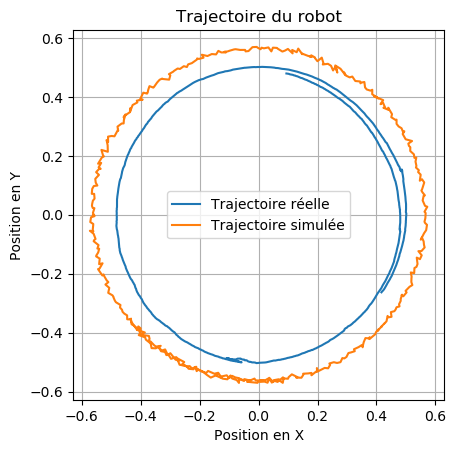

Centre du cercle réel avant offset: (-0.07039242467552427, 0.49917833397206984)
 
Centre du cercle simulé avant offset: (0.4747182130031958, 0.5098405315634489)
 
Rayon du cercle simulé: 0.4915 et rayon du cercle réel: 0.5642
Diamètre du cercle simulé: 0.9829 et diamètre du cercle réel: 1.1285
Périmètre du cercle simulé: 3.0879 et périmètre du cercle réel: 3.5452

Variance sur le rayon reél : 0.000074
Variance sur le rayon simulé : 0.000028
Moyenne sur le rayon réel: 0.491383
Moyenne sur le rayon simulé: 0.564219


In [16]:
#----------------------------------------------#
# Approximation du cercle par la méthode des moindres carrés
#----------------------------------------------#

# Fonction à minimiser pour trouver le cercle
def fun(params, x, y):
    xc, yc, r = params
    return (x - xc) ** 2 + (y - yc) ** 2 - r ** 2

# Estimation initiale des paramètres du cercle
params_real = [np.mean(X_real), np.mean(Y_real), np.std(X_real)]
params_sim = [np.mean(X_sim), np.mean(Y_sim), np.std(X_sim)]

# Optimisation des paramètres
res_real = least_squares(fun, params_real, args=(X_real, Y_real))
res_sim = least_squares(fun, params_sim, args=(X_sim, Y_sim))

# Extraction des paramètres du cercle
center_real = (res_real.x[0], res_real.x[1])
radius_real = res_real.x[2]
center_sim = (res_sim.x[0], res_sim.x[1])
radius_sim = res_sim.x[2]

#----------------------------------------------#
# Tracé de la trajectoire
#----------------------------------------------#
#On centre les graphiques en 0
X_graph_real = []
X_graph_sim = []
Y_graph_real = []
Y_graph_sim = []
for i in range(0, len(X_real)):
    X_graph_real.append(X_real[i]-center_real[0])
    Y_graph_real.append(Y_real[i]-center_real[1])

for i in range(0, len(X_sim)):
    X_graph_sim.append(X_sim[i]-center_sim[0])
    Y_graph_sim.append(Y_sim[i]-center_sim[1])

#Tracé
plt.plot(X_graph_real, Y_graph_real, label ='Trajectoire réelle')
plt.plot(X_graph_sim, Y_graph_sim, label ='Trajectoire simulée')

#Affiche 
plt.title('Trajectoire du robot')
plt.xlabel('Position en X')
plt.ylabel('Position en Y')
plt.gca().set_aspect('equal', adjustable='box') #Repère orthonormé
plt.grid()
plt.legend()
plt.show()

#----------------------------------------------#
# Calcul de la variance sur le rayon du cercle
# Calculs basés sur la détermination du centre du
# cercle déterminée précédémment
#----------------------------------------------#

liste_rayon_real = []
liste_rayon_sim = []

#Calcul des rayons pour chaque coordonnées (X,Y)
for i in range(0, len(X_real)):
    liste_rayon_real.append(np.sqrt(math.pow(Y_real[i]-center_real[1],2)+math.pow(X_real[i]-center_real[0],2)))
var_rayon_real = np.var(liste_rayon_real)  #Variance
moy_rayon_real = np.mean(liste_rayon_real) #Moyenne

for i in range(0, len(X_sim)):
    liste_rayon_sim.append(np.sqrt(math.pow(Y_sim[i]-center_sim[1],2)+math.pow(X_sim[i]-center_sim[0],2)))
var_rayon_sim = np.var(liste_rayon_sim)  #Variance
moy_rayon_sim = np.mean(liste_rayon_sim) #Moyenne

print(f"Centre du cercle réel avant offset: {center_real}\n ")
print(f"Centre du cercle simulé avant offset: {center_sim}\n ")

print(f"Rayon du cercle simulé: {radius_real:.4f} et rayon du cercle réel: {radius_sim:.4f}")
print(f"Diamètre du cercle simulé: {2*radius_real:.4f} et diamètre du cercle réel: {2*radius_sim:.4f}")

print(f"Périmètre du cercle simulé: {2*np.pi*radius_real:.4f} et périmètre du cercle réel: {2*np.pi*radius_sim:.4f}\n")

print("Variance sur le rayon réel : \033[31m{:.6f}\033[0m".format(var_rayon_real))
print("Variance sur le rayon simulé : \033[31m{:.6f}\033[0m".format(var_rayon_sim))

print("Moyenne sur le rayon réel: \033[92m{:.6f}\033[0m".format(moy_rayon_real))
print("Moyenne sur le rayon simulé: \033[92m{:.6f}\033[0m".format(moy_rayon_sim))

